In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text
from sqlalchemy import create_engine, text, Table, Column, Integer, String, Float, DateTime, MetaData

import pandas as pd
from urllib.parse import quote_plus

DB_USER = 'admin'
DB_PASS = 'Admin@1234Strong!'  
DB_HOST = '127.0.0.1'
DB_PORT = '3306'
TARGET_DB = 'lending_club'
DB_PASS_ENCODED = quote_plus(DB_PASS)

server_url = f"mysql+pymysql://{DB_USER}:{DB_PASS_ENCODED}@{DB_HOST}:{DB_PORT}/"
engine_server = create_engine(server_url)

try:
    with engine_server.connect() as conn:
        conn.execution_options(isolation_level="AUTOCOMMIT")
        conn.execute(text(f"CREATE DATABASE IF NOT EXISTS {TARGET_DB};"))
    print(f"Database '{TARGET_DB}' verified/created.")
except Exception as e:
    print(f"Connection Error: {e}")
    raise e

engine = create_engine(f"{server_url}{TARGET_DB}")
metadata = MetaData()



Database 'lending_club' verified/created.


In [20]:
with engine.connect() as conn:
    res = conn.execute(text("SELECT * FROM loans_processed LIMIT 0"))


    print("columns are:", res1.keys())

columns are: RMKeyView(['target', 'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_score', 'grade', 'home_ownership', 'emp_length_num'])


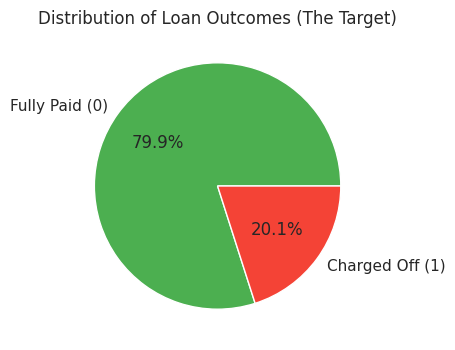

In [33]:

sns.set_theme(style="whitegrid")

query = "SELECT target, COUNT(*) as count FROM loans_processed GROUP BY target"
with engine.connect() as conn:
    data = pd.DataFrame(conn.execute(text(query)).fetchall())

plt.figure(figsize=(6, 4))
plt.pie(data['count'], labels=['Fully Paid (0)', 'Charged Off (1)'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title("Distribution of Loan Outcomes (The Target)")
plt.show()



# print("\nLoan Outcome Distribution:")
# for _, row in data.iterrows():
#     label = "Fully Paid" if row["target"] == 0 else "Charged Off"
#     print(f"{label}: {row['count']:,}")


/tmp/ipykernel_195090/644669905.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='avg_rate', data=data, palette="Reds_d")


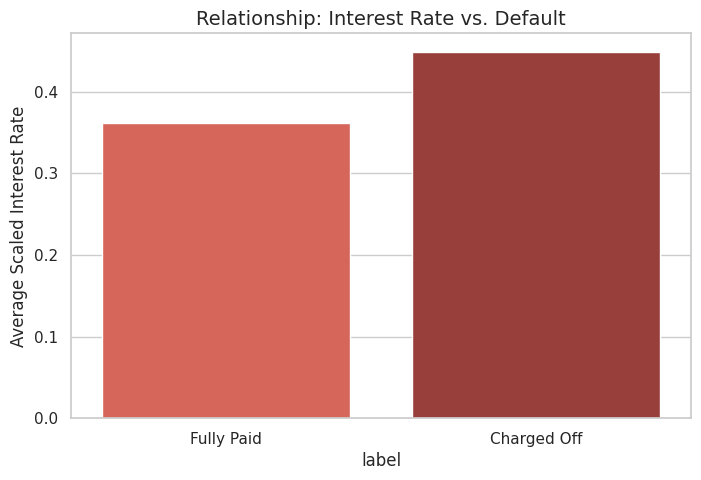


Average Scaled Interest Rate by Loan Outcome:
         label  avg_rate
0   Fully Paid  0.361164
1  Charged Off  0.448917


In [27]:
query = "SELECT target, AVG(rate_scaled) as avg_rate FROM loans_processed GROUP BY target"
with engine.connect() as conn:
    data = pd.DataFrame(conn.execute(text(query)).fetchall())

data['label'] = data['target'].map({0: 'Fully Paid', 1: 'Charged Off'})

plt.figure(figsize=(8, 5))
sns.barplot(x='label', y='avg_rate', data=data, palette="Reds_d")
plt.title("Relationship: Interest Rate vs. Default", fontsize=14)
plt.ylabel("Average Scaled Interest Rate")
plt.show()

print("\nAverage Scaled Interest Rate by Loan Outcome:")
print(data[['label', 'avg_rate']])


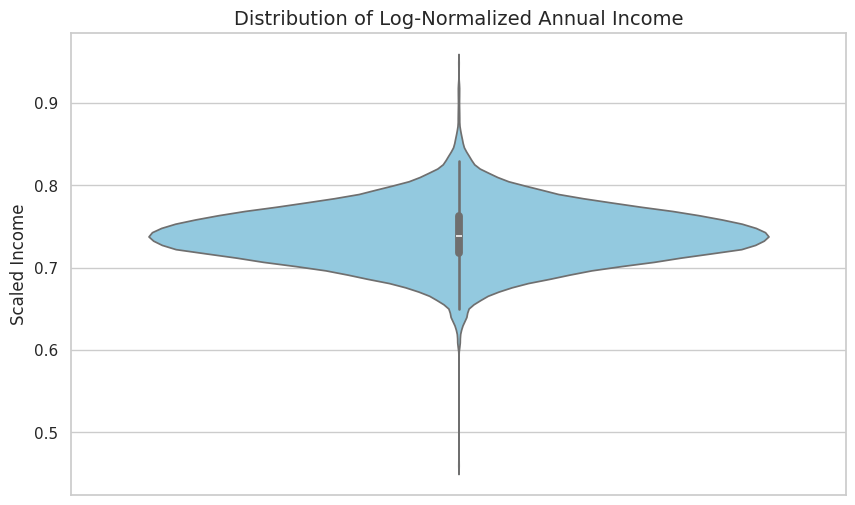


Scaled Income — Summary Statistics:
count    10000.000000
mean         0.739915
std          0.035471
min          0.460584
25%          0.717195
50%          0.738811
75%          0.762488
max          0.948065
Name: income_scaled, dtype: float64


In [28]:
query = "SELECT income_scaled FROM loans_processed LIMIT 10000"
with engine.connect() as conn:
    data = pd.DataFrame(conn.execute(text(query)).fetchall())

plt.figure(figsize=(10, 6))
sns.violinplot(y=data['income_scaled'], color="skyblue")
plt.title("Distribution of Log-Normalized Annual Income", fontsize=14)
plt.ylabel("Scaled Income")
plt.show()

print("\nScaled Income — Summary Statistics:")
print(data['income_scaled'].describe())


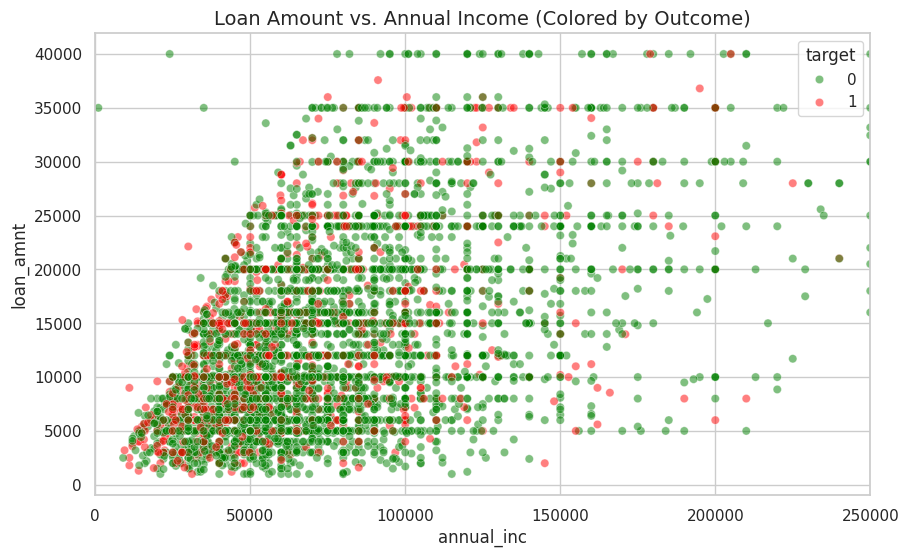


Loan Amount vs Annual Income Summary:
          annual_inc     loan_amnt
count    5000.000000   5000.000000
mean    76547.147664  13505.170000
std     50066.298162   8393.339779
min      1000.000000   1000.000000
25%     47000.000000   7000.000000
50%     65000.000000  11000.000000
75%     94000.000000  18425.000000
max    964434.000000  40000.000000

Class-wise summary by target:

Paid (3972 loans):
          annual_inc     loan_amnt
count    3972.000000   3972.000000
mean    79009.895257  13521.790030
std     51776.653704   8465.306088
min      1000.000000   1000.000000
25%     50000.000000   7000.000000
50%     68000.000000  11000.000000
75%     96000.000000  19000.000000
max    964434.000000  40000.000000

Default (1028 loans):
          annual_inc     loan_amnt
count    1028.000000   1028.000000
mean    67031.550934  13440.953307
std     41490.584075   8112.976062
min      9456.000000   1000.000000
25%     40000.000000   7175.000000
50%     57000.000000  11450.000000
75%     8500

In [43]:
query = "SELECT annual_inc, loan_amnt, target FROM loans_clean LIMIT 5000"
with engine.connect() as conn:
    data = pd.DataFrame(conn.execute(text(query)).fetchall())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='annual_inc', y='loan_amnt', hue='target', data=data, alpha=0.5, palette={0: 'green', 1: 'red'})
plt.xlim(0, 250000) 
plt.title("Loan Amount vs. Annual Income (Colored by Outcome)", fontsize=14)
plt.show()


print("\nLoan Amount vs Annual Income Summary:")

print(data[['annual_inc', 'loan_amnt']].describe())

print("\nClass-wise summary by target:")
for label, grp in data.groupby('target'):
    name = "Paid" if label == 0 else "Default"
    print(f"\n{name} ({len(grp)} loans):")
    print(grp[['annual_inc', 'loan_amnt']].describe())


# “Borrowers who default tend to have lower incomes than those who fully pay, while loan amounts are similar across classes; the dataset is right-skewed with a few extreme high-income outliers, and the target is imbalanced (~23% defaults), suggesting income and income-to-loan ratio as strong predictive features for default modeling.”


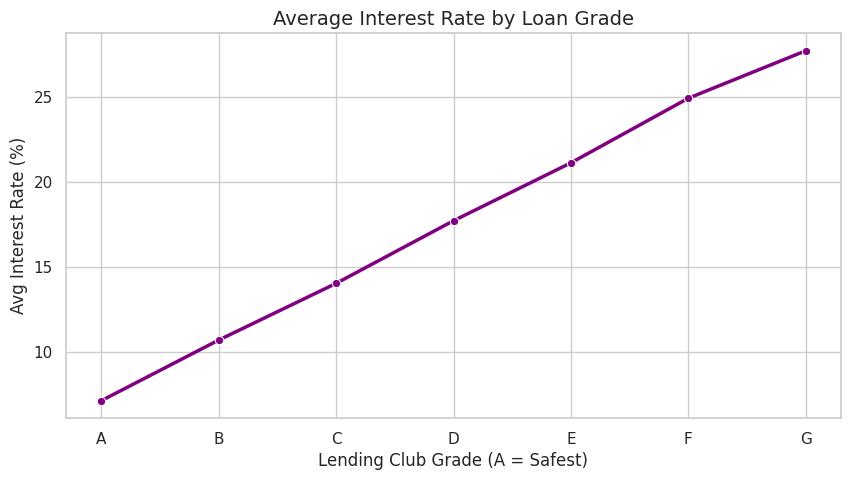


Average Interest Rate by Loan Grade:
  grade   avg_rate
0     A   7.124555
1     B  10.688107
2     C  14.020655
3     D  17.700315
4     E  21.102467
5     F  24.898567
6     G  27.688071


In [30]:
# SQL Aggregation: Calculating average interest per grade
query = "SELECT grade, AVG(int_rate) as avg_rate FROM loans_clean GROUP BY grade ORDER BY grade"
with engine.connect() as conn:
    data = pd.DataFrame(conn.execute(text(query)).fetchall())

plt.figure(figsize=(10, 5))
sns.lineplot(x='grade', y='avg_rate', data=data, marker='o', color='purple', linewidth=2.5)
plt.title("Average Interest Rate by Loan Grade", fontsize=14)
plt.ylabel("Avg Interest Rate (%)")
plt.xlabel("Lending Club Grade (A = Safest)")
plt.show()


print("\nAverage Interest Rate by Loan Grade:")
print(data[['grade', 'avg_rate']])


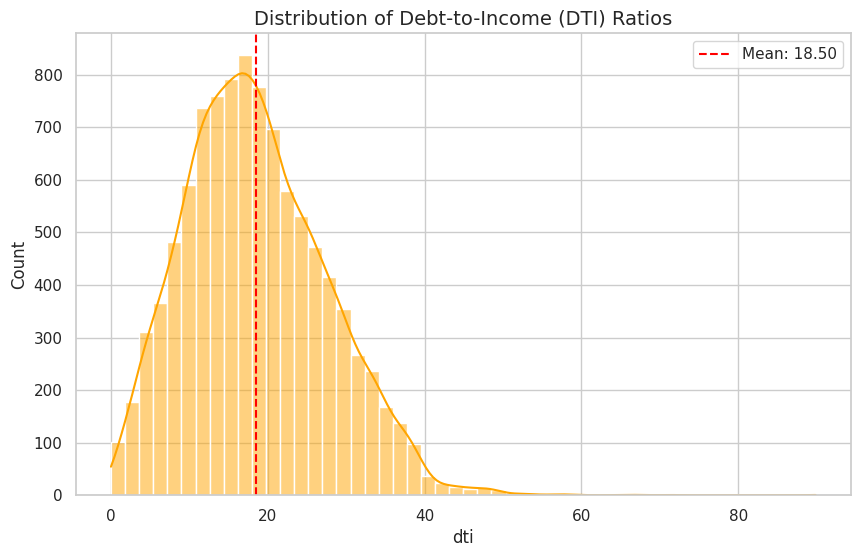


Debt-to-Income (DTI) Distribution:
Count : 10,000
Mean  : 18.50
Median: 17.65
Std   : 8.99
Min   : 0.00
Max   : 89.85


In [32]:
query = "SELECT dti FROM loans_clean WHERE dti < 100 LIMIT 10000" 
with engine.connect() as conn:
    data = pd.DataFrame(conn.execute(text(query)).fetchall())

plt.figure(figsize=(10, 6))
sns.histplot(data['dti'], bins=50, kde=True, color='orange')
plt.axvline(data['dti'].mean(), color='red', linestyle='--', label=f"Mean: {data['dti'].mean():.2f}")
plt.title("Distribution of Debt-to-Income (DTI) Ratios", fontsize=14)
plt.legend()
plt.show()


# s = data['dti']

# print("\nDebt-to-Income (DTI) Distribution:")
# print(f"Count : {len(s):,}")
# print(f"Mean  : {s.mean():.2f}")
# print(f"Median: {s.median():.2f}")
# print(f"Std   : {s.std():.2f}")
# print(f"Min   : {s.min():.2f}")
# print(f"Max   : {s.max():.2f}")


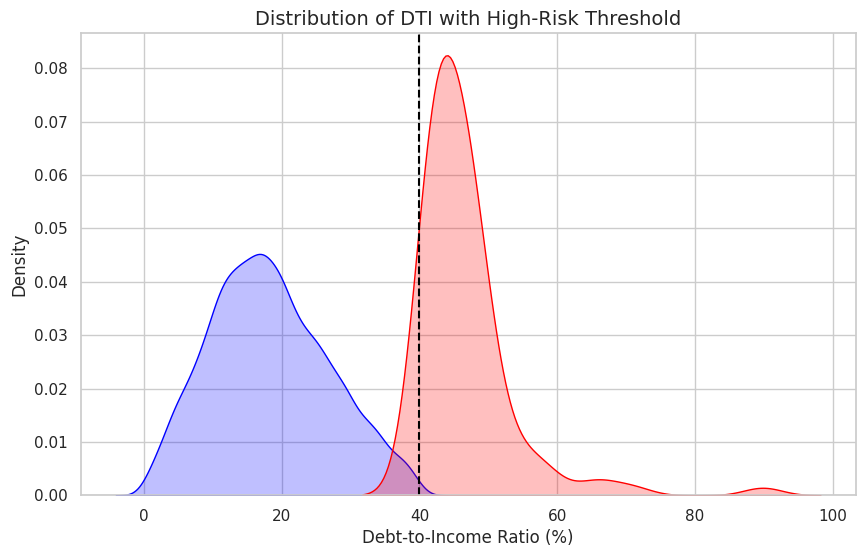

DTI Summary Statistics:

Safe Zone (<40%):
  Count  : 9898
  Mean   : 18.21
  Median : 17.55
  Max    : 39.99

Danger Zone (>=40%):
  Count  : 102
  Mean   : 46.52
  Median : 44.86
  Max    : 89.85

Percentage of High-Risk Borrowers (DTI>=40): 1.0%


In [45]:
query = "SELECT dti FROM loans_clean WHERE dti < 100 LIMIT 10000"
with engine.connect() as conn:
    data = pd.DataFrame(conn.execute(text(query)).fetchall())

plt.figure(figsize=(10, 6))
sns.kdeplot(data[data['dti'] < 40]['dti'], fill=True, color="blue", label="Safe Zone")
sns.kdeplot(data[data['dti'] >= 40]['dti'], fill=True, color="red", label="Danger Zone")
plt.axvline(40, color='black', linestyle='--')
plt.title("Distribution of DTI with High-Risk Threshold", fontsize=14)
plt.xlabel("Debt-to-Income Ratio (%)")
plt.show()



safe = data[data['dti'] < 40]['dti']
danger = data[data['dti'] >= 40]['dti']

print("DTI Summary Statistics:\n")

print(f"Safe Zone (<40%):")
print(f"  Count  : {len(safe)}")
print(f"  Mean   : {safe.mean():.2f}")
print(f"  Median : {safe.median():.2f}")
print(f"  Max    : {safe.max():.2f}")

print(f"\nDanger Zone (>=40%):")
print(f"  Count  : {len(danger)}")
print(f"  Mean   : {danger.mean():.2f}")
print(f"  Median : {danger.median():.2f}")
print(f"  Max    : {danger.max():.2f}")

print(f"\nPercentage of High-Risk Borrowers (DTI>=40): {len(danger)/len(data)*100:.1f}%")
